# Building our models: ALS recommender + Deep Neural Network

### In this notebook we build and test our models: an ALS recommendation system for generating additional hashtags, and a deep neural network for classifying new images to solve the cold start problem. 

### If you wish to reproduce the training steps taken here, you will of course need the dataset. Sadly the 1,500 pictures we used exceed Git's file storage allowances, so you will need to scrape your own images (and of course their associated hashtags). Please refer to scraping.ipynb which features a fully automated pipeline for doing this. 

In [2]:
# TensorFlow 2.0.0 is required for this code to work.
# Uncomment and run the following line to install the CPU version.
# !pip install tensorflow==2.0.0-beta0 --ignore-installed

In [1]:
%load_ext autoreload
%autoreload 2

### Import necessary modules:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from random import shuffle
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS, ALSModel
from sklearn.model_selection import train_test_split
from functools import reduce
from functions import prepare_image, extract_features
import os
import json
from PIL import Image

### Get a list of all hashtags

In [4]:
json_file_names = os.listdir('json_files')
# Remove the 5 char .json file ending to isolate hashtag name
hashtags = [hashtag[:-5] for hashtag in json_file_names]

In [5]:
# remove '.DS_', '.ipynb_checkp'
non_hashtags = ['.DS_', '.ipynb_checkp']
for non_hashtag in non_hashtags:
    try:
        hashtags.remove(non_hashtag)
    except:
        pass # If we can't remove it, it's already gone
    
hashtags

['fitness',
 'selfie',
 'travel',
 'nature',
 'babies',
 'cars',
 'food',
 'architecture',
 'animals',
 'wedding']

In [6]:
hashtag_dfs = []
for hashtag in hashtags: 
    hashtag_dfs.append(pd.read_json(f'json_files/{hashtag}.json'))
df = reduce(lambda x, y: pd.concat([x, y]), hashtag_dfs)

In [7]:
full_list = pd.DataFrame.reset_index(df, drop=True)

In [8]:
full_list.tail()

,hashtags,image,image_local_name,post_link,search_hashtag
2995,"[#Wedding, #ido, #ianandwendytietheknot, #wedd...",https://scontent-sea1-1.cdninstagram.com/vp/29...,905a1d9c-b29d-44c7-ab5c-408c0b5d91ac.jpg,https://www.instagram.com/p/B0dcq0FBPQ3/,wedding
2996,"[#wedding, #mariages, #celebrantecuritiba, #ce...",https://scontent-sea1-1.cdninstagram.com/vp/bb...,6e424f02-d10e-42db-a233-9ce2724fb8a9.jpg,https://www.instagram.com/p/BwXbu7MgCTZ/,wedding
2997,"[#weddingring, #wedding, #shoes, #nancy, #sigm...",https://scontent-sea1-1.cdninstagram.com/vp/25...,ae49d2bb-95f7-4d16-9ee5-1603e97e6dd8.jpg,https://www.instagram.com/p/B0gwuc2icKv/,wedding
2998,"[#wedding, #standesamtgoetheallee, #retroweddi...",https://scontent-sea1-1.cdninstagram.com/vp/21...,9152a6d4-abda-4adf-87a4-7988dc4bb3ac.jpg,https://www.instagram.com/p/B0gwufzImAz/,wedding
2999,"[#kinalik, #gelinlik, #bursad, #wedding, #dama...",https://scontent-sea1-1.cdninstagram.com/vp/15...,09aaa471-2ed6-4ead-84db-e4aa6b0ece8f.jpg,https://www.instagram.com/p/B0gwubDhu6M/,wedding


### Resizing image to be used in tensorflow framework for Deep Feature Extraction

In [9]:
pics = []
for i, row in full_list.iterrows():
    name = row['image_local_name']
    hashtag = row['search_hashtag']
    img_path = f'data/{hashtag}/{name}'
    try:
        img = prepare_image(img_path, where='local')
        pics.append({'pic': img, 'hashtag': hashtag, 'name': name})
    except:
        # If a file in the list isn't in 
        # storage, skip it and continue
        pass

In [10]:
type(pics[64]['pic'])

tensorflow.python.framework.ops.EagerTensor

W0829 17:04:07.344176 4694390208 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


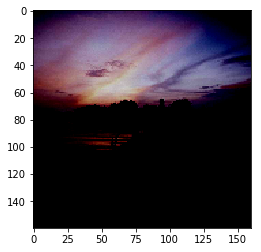

In [11]:
plt.imshow(pics[64]['pic']);

In [12]:
# Add extracted deep features information to pics, make it a list of dictionaries
deep_features = list(map(extract_features, pics))

In [15]:
# Check the first element of the train set
pic = train[0]
pic.keys()

dict_keys(['pic', 'hashtag', 'name', 'deep_features'])

W0829 17:05:21.783342 4694390208 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


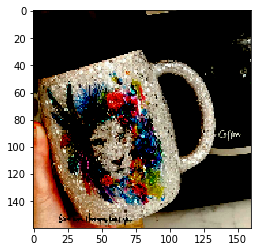

In [16]:
plt.imshow(pic['pic']);

In [17]:
pic['hashtag'], pic['deep_features'].shape, pic['pic'].shape

('babies', (1280,), TensorShape([160, 160, 3]))

In [53]:
df = pd.DataFrame(deep_features)
df.head()

,deep_features,hashtag,name,pic
0,"[0.09537401, 0.0, 0.0, 1.3010054, 0.06189001, ...",babies,c7859ea9-d0d4-491e-af91-d91e9a8c122b.jpg,"(((tf.Tensor(-0.3705882, shape=(), dtype=float..."
1,"[0.0, 0.08503536, 0.9841172, 0.79477465, 2.028...",animals,45d6c48c-c25e-42fc-854f-df71bf6de43e.jpg,"(((tf.Tensor(0.627451, shape=(), dtype=float32..."
2,"[0.0, 0.1421825, 0.29680955, 0.461614, 0.10577...",architecture,0b51899b-dc3c-4f30-9230-3f5223cf79a6.jpg,"(((tf.Tensor(0.52156866, shape=(), dtype=float..."
3,"[0.2723638, 0.07413437, 1.3867798, 0.0, 0.3256...",animals,6ca3e818-6023-43d8-bf47-e958a52f0530.jpg,"(((tf.Tensor(0.3921569, shape=(), dtype=float3..."
4,"[0.0, 0.0, 0.4716914, 0.0, 0.0, 2.7325175, 0.8...",animals,b1d7803e-68cc-4bed-9d7c-ed0590899403.jpg,"(((tf.Tensor(-0.1607843, shape=(), dtype=float..."


In [20]:
filepath = "pkl_files/df_deep_features.pkl"
if os.path.exists(filepath):
    df.to_pickle(filepath)

## ALS Model

In [21]:
spark = SparkSession.builder.master('local').getOrCreate()

In [22]:
# Train test split full_list. Not used in the model. Use code when necessary.
train, test = train_test_split(full_list, test_size=0.2)

len(train), len(test), len(full_list)

(2400, 600, 3000)

In [23]:
train.head()

,hashtags,image,image_local_name,post_link,search_hashtag
2324,[architecture],NaN,cffd5558-a181-48fd-b9c7-a5d827c06ecd.jpg,NaN,architecture
780,"[#goinghometoday, #travel, #waithing, #traveli...",https://scontent-lga3-1.cdninstagram.com/vp/2d...,cab8d69a-9704-48da-b48e-f4594a2acdbd.jpg,https://www.instagram.com/p/By3OGJTBNhL/,travel
2584,"[#repost, #apoya, #loveanimals, #ayudanosayuda...",https://scontent-lga3-1.cdninstagram.com/vp/c8...,60784411-c999-459a-b7ba-3dddcaae8a20.jpg,https://www.instagram.com/p/By3oLsPF-2G/,animals
2519,"[#puppydog, #animal, #valdivia, #greyhound, #d...",https://scontent-lga3-1.cdninstagram.com/vp/91...,4d1db65c-c0de-4191-9703-ba6a3f986a13.jpg,https://www.instagram.com/p/By3od_PpNTa/,animals
2916,"[#tanaandjake, #logangsters, #dentingtheuniver...",https://scontent-sea1-1.cdninstagram.com/vp/d6...,bdae9c3a-c90e-4278-b399-754e6227e7ef.jpg,https://www.instagram.com/p/B0gwzbag2ge/,wedding


In [24]:
full_list.head()

,hashtags,image,image_local_name,post_link,search_hashtag
0,"[#herbalifeshake, #kilokontrol, #herbalife, #h...",https://scontent-mad1-1.cdninstagram.com/vp/bd...,ff07fa3f-0482-4757-926e-3e6229f7d0d7.jpg,https://www.instagram.com/p/B02xq0AFpe9/,fitness
1,[],https://scontent-mad1-1.cdninstagram.com/vp/b9...,7cff7c70-b983-4c6b-adee-fc5676acddf3.jpg,https://www.instagram.com/p/B02sMkwJnny/,fitness
2,"[#bollywood, #indian, #art, #love, #india, #gi...",https://scontent-mad1-1.cdninstagram.com/vp/2b...,b7de6dac-4294-45d5-aac0-8a749b7e4cc5.jpg,https://www.instagram.com/p/B02zfuaDfP4/,fitness
3,"[#popxodaily, #personalblog, #loveforblack, #l...",https://scontent-mad1-1.cdninstagram.com/vp/34...,f699faef-b071-46f2-bf5c-fd9f1ff7626a.jpg,https://www.instagram.com/p/B02yOH3nfzB/,fitness
4,[],https://scontent-mad1-1.cdninstagram.com/vp/31...,7f25fd41-5f1b-4181-8128-4f7464f4c2ad.jpg,https://www.instagram.com/p/B02rDHDF28T/,fitness


In [25]:
full_list['clean_hashtags'] = full_list['hashtags'].apply(
    lambda hashtag_list: [h for h in hashtag_list if h.startswith('#')])

In [26]:
full_list.head()

,hashtags,image,image_local_name,post_link,search_hashtag,clean_hashtags
0,"[#herbalifeshake, #kilokontrol, #herbalife, #h...",https://scontent-mad1-1.cdninstagram.com/vp/bd...,ff07fa3f-0482-4757-926e-3e6229f7d0d7.jpg,https://www.instagram.com/p/B02xq0AFpe9/,fitness,"[#herbalifeshake, #kilokontrol, #herbalife, #h..."
1,[],https://scontent-mad1-1.cdninstagram.com/vp/b9...,7cff7c70-b983-4c6b-adee-fc5676acddf3.jpg,https://www.instagram.com/p/B02sMkwJnny/,fitness,[]
2,"[#bollywood, #indian, #art, #love, #india, #gi...",https://scontent-mad1-1.cdninstagram.com/vp/2b...,b7de6dac-4294-45d5-aac0-8a749b7e4cc5.jpg,https://www.instagram.com/p/B02zfuaDfP4/,fitness,"[#bollywood, #indian, #art, #love, #india, #gi..."
3,"[#popxodaily, #personalblog, #loveforblack, #l...",https://scontent-mad1-1.cdninstagram.com/vp/34...,f699faef-b071-46f2-bf5c-fd9f1ff7626a.jpg,https://www.instagram.com/p/B02yOH3nfzB/,fitness,"[#popxodaily, #personalblog, #loveforblack, #l..."
4,[],https://scontent-mad1-1.cdninstagram.com/vp/31...,7f25fd41-5f1b-4181-8128-4f7464f4c2ad.jpg,https://www.instagram.com/p/B02rDHDF28T/,fitness,[]


In [27]:
image_lookup = dict(zip(full_list['image_local_name'], full_list.index))

In [28]:
all_hashtags = set()
for tags in full_list['clean_hashtags']:
    all_hashtags.update(tags)
hashtag_lookup = {hashtag: i for i, hashtag in enumerate(all_hashtags)}

In [29]:
hashtag_data = []
for i in full_list.index:
    hashtags = full_list.loc[i, 'clean_hashtags']
    for hashtag in hashtags:
        hashtag_data.append(
            {'image_id': i,
             'hashtag_id': hashtag_lookup[hashtag],
             'rating': 1}
        )
hashtag_df_long = pd.DataFrame(hashtag_data)

In [30]:
hashtag_df_long.tail()

,hashtag_id,image_id,rating
47467,4863,2999,1
47468,13141,2999,1
47469,1215,2999,1
47470,3137,2999,1
47471,3277,2999,1


In [31]:
full_list.dtypes

hashtags            object
image               object
image_local_name    object
post_link           object
search_hashtag      object
clean_hashtags      object
dtype: object

In [32]:
als = ALS(userCol='image_id',
          itemCol='hashtag_id',
          implicitPrefs=True,
          alpha=40)

In [33]:
hashtag_spark_df = spark.createDataFrame(hashtag_df_long)

In [34]:
als_model = als.fit(hashtag_spark_df)

In [35]:
als_model.write().overwrite().save('als')

In [36]:
# Load the ALS model
# als_model = ALSModel.load(“/path/to/read/the/model/from”)

In [37]:
recs = als_model.recommendForAllUsers(numItems=10).toPandas()
len(recs)

2261

In [38]:
hashtag_index = list(all_hashtags)

In [39]:
def lookup_hashtag(hashtag_id):
    return hashtag_index[hashtag_id]

In [40]:
def lookup_hashtag_recs(rec_scores):
    return [lookup_hashtag(rec) for (rec, score) in rec_scores]

In [41]:
recs['recommended_hashtags'] = recs['recommendations'].apply(lookup_hashtag_recs)

In [42]:
recs.index = recs['image_id']

In [43]:
compare_recs = recs.join(full_list, how='left')[['recommendations',
                                                 'recommended_hashtags',
                                                 'hashtags',
                                                 'image_local_name',
                                                 'search_hashtag']]

In [44]:
compare_recs.loc[0, 'image_local_name']

'ff07fa3f-0482-4757-926e-3e6229f7d0d7.jpg'

In [45]:
compare_recs.to_pickle('pkl_files/recs.pkl')
compare_recs.drop('recommendations', axis=1)
image_factors = als_model.userFactors.toPandas()
image_factors.index = image_factors['id']
compare_recs.join(image_factors);

### Pickle hashtag data

In [46]:
len(hashtag_lookup), type(hashtag_lookup)

(15248, dict)

In [47]:
hashtags_df = pd.DataFrame.from_dict(hashtag_lookup, orient='index')
hashtags_df.head()

,0
#sushiemcasa,0
#retarded,1
#weddingflowersdecor,2
#booster,3
#kumas,4


In [48]:
hashtags_df = hashtags_df.reset_index()
hashtags_df.columns = ['hashtag', 'id']

In [49]:
hashtags_df.index = hashtags_df['id']

In [50]:
hashtags_df = hashtags_df.drop('id', axis=1)

In [51]:
hashtags_df.head()

,hashtag
id,
0,#sushiemcasa
1,#retarded
2,#weddingflowersdecor
3,#booster
4,#kumas


In [52]:
hashtags_df.to_pickle("pkl_files/hashtags_df.pkl")

In [33]:
# Load the deep features dataframe
deep_features = pd.read_pickle("pkl_files/df_deep_features.pkl")

In [33]:
deep_features.index = deep_features['name']
deep_features.head()

,deep_features,hashtag,name,pic
name,,,,
c7859ea9-d0d4-491e-af91-d91e9a8c122b.jpg,"[0.09537401, 0.0, 0.0, 1.3010054, 0.06189001, ...",babies,c7859ea9-d0d4-491e-af91-d91e9a8c122b.jpg,"(((tf.Tensor(-0.3705882, shape=(), dtype=float..."
45d6c48c-c25e-42fc-854f-df71bf6de43e.jpg,"[0.0, 0.08503536, 0.9841172, 0.79477465, 2.028...",animals,45d6c48c-c25e-42fc-854f-df71bf6de43e.jpg,"(((tf.Tensor(0.627451, shape=(), dtype=float32..."
0b51899b-dc3c-4f30-9230-3f5223cf79a6.jpg,"[0.0, 0.1421825, 0.29680955, 0.461614, 0.10577...",architecture,0b51899b-dc3c-4f30-9230-3f5223cf79a6.jpg,"(((tf.Tensor(0.52156866, shape=(), dtype=float..."
6ca3e818-6023-43d8-bf47-e958a52f0530.jpg,"[0.2723638, 0.07413437, 1.3867798, 0.0, 0.3256...",animals,6ca3e818-6023-43d8-bf47-e958a52f0530.jpg,"(((tf.Tensor(0.3921569, shape=(), dtype=float3..."
b1d7803e-68cc-4bed-9d7c-ed0590899403.jpg,"[0.0, 0.0, 0.4716914, 0.0, 0.0, 2.7325175, 0.8...",animals,b1d7803e-68cc-4bed-9d7c-ed0590899403.jpg,"(((tf.Tensor(-0.1607843, shape=(), dtype=float..."


In [35]:
# Load the recs dataframe
recs = pd.read_pickle('pkl_files/recs.pkl')
recs.head()

,recommendations,recommended_hashtags,hashtags,image_local_name,search_hashtag
image_id,,,,,
1580,"[(5249, 1.1879390478134155), (6758, 1.06600213...","[#luxury, #car, #lifestyle, #cars, #luxurylife...","[#checkeredflag, #atv, #flagmanracing, #dirtbi...",88039d35-d189-4db3-926e-a120d88a3efc.jpg,cars
471,"[(5728, 1.1468442678451538), (1048, 1.14258015...","[#selfie, #amazing, #fashion, #black, #photo, ...","[#followme, #fashiondaily, #summer, #food, #ma...",fdc6c8d4-5a13-4330-9098-07e09e4858d2.jpg,selfie
1591,"[(15043, 0.8404358625411987), (6758, 0.6228702...","[#cars, #car, #bmw, #trucks, #amazing, #carpor...","[#bidlemanchevrolet, #suvs, #cars, #cardeals, ...",1b7a8fbc-1797-4418-b8b2-c65500e2bc6f.jpg,cars
463,"[(5728, 0.781302809715271), (7432, 0.773969054...","[#selfie, #beauty, #smile, #style, #fashion, #...","[#followme, #hotguy, #instaboy, #gay, #instaga...",a78d0e30-6afa-436a-a953-633ef3f64325.jpg,selfie
833,"[(2932, 1.0711742639541626), (11435, 0.8931126...","[#explore, #art, #nature, #photography, #archi...","[#arte, #interiordesign, #archilovers, #argent...",535bc893-ebbe-46aa-9ae9-d2cd5f4dd426.jpg,travel


In [36]:
# Add deep features information to recs dataframe
recs_deep = recs.join(deep_features, on='image_local_name', how='inner')
recs_deep.head()

,recommendations,recommended_hashtags,hashtags,image_local_name,search_hashtag,deep_features,hashtag,name,pic
image_id,,,,,,,,,
833,"[(2932, 1.0711742639541626), (11435, 0.8931126...","[#explore, #art, #nature, #photography, #archi...","[#arte, #interiordesign, #archilovers, #argent...",535bc893-ebbe-46aa-9ae9-d2cd5f4dd426.jpg,travel,"[0.40182838, 0.0, 0.028864231, 0.0, 0.13101286...",travel,535bc893-ebbe-46aa-9ae9-d2cd5f4dd426.jpg,"(((tf.Tensor(0.99215686, shape=(), dtype=float..."
1829,"[(8334, 0.6680111885070801), (7957, 0.56452876...","[#food, #fitness, #instafood, #foodporn, #nyc,...","[#bhcidadecriativadagastronomia, #prato, #come...",56018a9a-8def-48d1-9a7d-03136314b0d9.jpg,food,"[0.0, 0.0, 0.0, 2.0659437, 0.06043254, 0.03285...",food,56018a9a-8def-48d1-9a7d-03136314b0d9.jpg,"(((tf.Tensor(0.7882353, shape=(), dtype=float3..."
1959,"[(7436, 1.0163105726242065), (8334, 0.96548527...","[#instafood, #food, #foodporn, #foodie, #yummy...","[#hagerstownmd, #washingtoncountymd, #hswhmdbu...",2b98b605-8df1-4fcb-addf-887751caaaaa.jpg,food,"[0.2551278, 0.6026027, 0.0, 0.0, 0.2649013, 0....",food,2b98b605-8df1-4fcb-addf-887751caaaaa.jpg,"(((tf.Tensor(-1.0, shape=(), dtype=float32), t..."
2659,"[(15161, 0.9028208255767822), (11773, 0.811946...","[#animals, #pets, #animal, #dogs, #dogstagram,...","[#sportdogminsk, #dogminsk, #labrador, #labrad...",c62f34b0-da93-485c-94a0-d56be4b72018.jpg,animals,"[0.0, 1.7648926, 0.0, 0.014228077, 0.114186764...",animals,c62f34b0-da93-485c-94a0-d56be4b72018.jpg,"(((tf.Tensor(0.07843143, shape=(), dtype=float..."
1990,"[(2753, 1.0034533739089966), (12956, 0.9917454...","[#follow, #like, #followme, #likeforlike, #ins...","[#follow, #photooftheday, #love, #instalike, #...",7263d6f8-422f-4484-a306-cf9984bfa8bc.jpg,food,"[0.0, 0.0, 0.24697302, 0.0, 0.0, 0.025176601, ...",food,7263d6f8-422f-4484-a306-cf9984bfa8bc.jpg,"(((tf.Tensor(-0.9079044, shape=(), dtype=float..."


In [16]:
# Only use certain columns
recs_deep_clean = recs_deep[['image_local_name', 'hashtags', 'deep_features']]

img_features.index = img_features['id']
img_features.drop(['id'], axis=1)

# Add image feature into dataframe
recommender_df = recs_deep_clean.join(img_features, how='inner')
recommender_df.head()

,image_local_name,hashtags,deep_features,id,features
833,535bc893-ebbe-46aa-9ae9-d2cd5f4dd426.jpg,"[#arte, #interiordesign, #archilovers, #argent...","[0.40182838, 0.0, 0.028864231, 0.0, 0.13101286...",833,"[0.6194280982017517, -0.17258895933628082, 0.6..."
1829,56018a9a-8def-48d1-9a7d-03136314b0d9.jpg,"[#bhcidadecriativadagastronomia, #prato, #come...","[0.0, 0.0, 0.0, 2.0659437, 0.06043254, 0.03285...",1829,"[0.24641281366348267, 0.0611935593187809, -0.0..."
1959,2b98b605-8df1-4fcb-addf-887751caaaaa.jpg,"[#hagerstownmd, #washingtoncountymd, #hswhmdbu...","[0.2551278, 0.6026027, 0.0, 0.0, 0.2649013, 0....",1959,"[0.4338062107563019, -0.33095109462738037, -0...."
2659,c62f34b0-da93-485c-94a0-d56be4b72018.jpg,"[#sportdogminsk, #dogminsk, #labrador, #labrad...","[0.0, 1.7648926, 0.0, 0.014228077, 0.114186764...",2659,"[0.5307531356811523, -0.20263993740081787, 0.1..."
1990,7263d6f8-422f-4484-a306-cf9984bfa8bc.jpg,"[#follow, #photooftheday, #love, #instalike, #...","[0.0, 0.0, 0.24697302, 0.0, 0.0, 0.025176601, ...",1990,"[-0.08636502921581268, -0.30729246139526367, 0..."


In [17]:
# Code used for testing purposes
from imp import reload
import functions
reload(functions)
prepare_image = functions.prepare_image

In [18]:
# Function that finds k nearest neighbors by cosine similarity
def find_neighbor_vectors(image_path, k=5, recommender_df=recommender_df):
    """Find image features (user vectors) for similar images."""
    prep_image = functions.prepare_image(image_path, where='local')
    deep_features = functions.extract_features_for_one_image(prep_image, neural_network)
    rdf = recommender_df.copy()
    rdf['dist'] = rdf['deep_features'].apply(lambda x: cosine(x, deep_features))
    rdf = rdf.sort_values(by='dist')
    # return rdf.head(k)['features']
    return rdf.head(k)

In [19]:
# Test the function on a local image
fnv = find_neighbor_vectors('test_wedding.jpg', 
                k=5, recommender_df=recommender_df)

In [20]:
fnv

,image_local_name,hashtags,deep_features,id,features,dist
763,edf9daee-f603-46b5-bf4a-ae9974bb89ad.jpg,"[#wanderlust, #toddlers, #woods, #forest, #nc,...","[0.74691504, 1.2644943, 0.0, 0.23730093, 2.684...",763,"[0.4171702265739441, -0.017076052725315094, -0...",0.420474
882,c3b7232e-ea7c-4766-91e3-99207f7d8d8b.jpg,"[#photooftheday, #hasekio, #bs, #travel, #phot...","[0.7826781, 1.8151407, 0.3264235, 0.4332988, 1...",882,"[-0.2053070217370987, -0.8706239461898804, 0.3...",0.437234
682,e1626e8a-eaa8-4812-917b-4a4aeadeb10f.jpg,"[#follow, #repost, #photooftheday, #love, #fas...","[0.17159231, 0.4535152, 0.023434391, 0.1585964...",682,"[0.07097786664962769, -0.32791000604629517, 0....",0.456072
773,72569f9f-ebea-4b5a-b238-c2b15e9b288d.jpg,"[#musician, #newmusic, #producer, #futuremusic...","[0.019124918, 1.6645181, 0.0, 0.0, 2.546588, 0...",773,"[0.1564265638589859, 0.18779335916042328, 0.08...",0.461755
737,f2a6f5f1-64c2-4ee3-9609-d409e28fa816.jpg,"[#honolulu, #hawaii, #dream, #travel, #hoomalu...","[0.13907114, 0.9570846, 0.052211534, 0.0, 1.52...",737,"[0.1638672947883606, 0.05539854243397713, 0.13...",0.470721


### Next step to do: after identifying 5 nearest neighbors, look at ALS's image features (user features), get the average for 5. Then compute dot product with every hashtag features vector (item features). Take hashtags woth the highest reasult as recommendations.

In [21]:
# Check length of the user features
len(fnv.iloc[3, 4])

10

## Find the average of the 5 user features found based on cosine similarity.

In [22]:
# Extract features from dataframe
features = []
for item in fnv.features.values:
    features.append(item)

In [23]:
avg_features = np.mean(np.asarray(features), axis=0)

## Find the dot product with each hashtag features

In [24]:
# Take a look at the hashtag features extracted from ALS model
hashtag_features.head()

,id,features
0,1,"[0.0744522213935852, 0.0064070881344377995, 0...."
1,11,"[0.054107919335365295, 0.08664730191230774, 0...."
2,21,"[-0.04549521207809448, -0.06504690647125244, -..."
3,31,"[0.05305836722254753, 0.07028129696846008, -0...."
4,41,"[-0.03151167184114456, 0.029394743964076042, 0..."


In [25]:
# Add new column to the hashtag features which will be the dot product with the average image(user) features
hashtag_features['dot_product'] = hashtag_features['features'].apply(lambda x: np.asarray(x).dot(avg_features))

# Get 10 ids with the highest dot product
df_ten_highest = hashtag_features.sort_values(by='dot_product', ascending=False).head(10)
rec_hashtag_ids = df_ten_highest.id.values

## Find hashtags that correspond to the ids

In [31]:
# Unpickle hashtag data
hashtags_df = pd.read_pickle("pkl_files/hashtags_df.pkl")
hashtags_df.head()

,hashtag
id,
0,#sushiemcasa
1,#retarded
2,#weddingflowersdecor
3,#booster
4,#kumas


In [32]:
for i in rec_hashtag_ids:
    print(hashtags_df.loc[hashtags_df.index==i]['hashtag'])

id
14094    #travel
Name: hashtag, dtype: object
id
4515    #photography
Name: hashtag, dtype: object
id
2638    #nature
Name: hashtag, dtype: object
id
4556    #love
Name: hashtag, dtype: object
id
305    #photooftheday
Name: hashtag, dtype: object
id
14520    #instagood
Name: hashtag, dtype: object
id
3319    #picoftheday
Name: hashtag, dtype: object
id
775    #beautiful
Name: hashtag, dtype: object
id
9326    #summer
Name: hashtag, dtype: object
id
6746    #instagram
Name: hashtag, dtype: object
